### Imports

In [1]:
import importlib
import traceback
import os
import re
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import findatree.io as io
import findatree.photometric as photometric
import findatree.transformations as transformations

_ = importlib.reload(io)
_ = importlib.reload(photometric)
_ = importlib.reload(transformations)

plt.style.use(r'C:\Repos\findatree\own.mplstyle')

### Definitions

In [58]:
# Define directories where return hdf5s are stored
dir_name_hdf5 = r"C:\Data\lwf\processed\2020\hdf5"

# Vegetation indices used in px-wise correlation
vi_names = ['ndvi', 'ndvire', 'ndre', 'grvi', 'chm']

# Collect pixel wise correlation of 10 random tnrs
n_random_tnrs = 0

# Optionally process only specific tnrs
include_tnrs = [
    # 15519,
]

### Processing

#### Prepare main loop

In [59]:
# Get all available tnr numbers in directory
paths = [os.path.join(dir_name_hdf5, name) for name in os.listdir(dir_name_hdf5) if os.path.splitext(name)[-1] == '.hdf5']



# Include only specified tnrs in main loop
if len(include_tnrs) > 0:
    paths_keep = []
    for tnr in include_tnrs:
        pattern_tnr = 'tnr' + str(tnr)
        paths_keep.extend([p for p in paths if bool(re.search(pattern_tnr, os.path.split(p)[-1], re.IGNORECASE)) ] )
    print('Following files will be included in main loop:')
    for p in paths_keep: print(' '*3, p)
elif n_random_tnrs > 0:
    paths_keep = [paths[i] for i in np.random.randint(0, len(paths), n_random_tnrs)]
    for p in paths_keep: print(' '*3, p)
else:
    paths_keep = paths.copy()

#### Run main loop
* Load channels and crowns
* Filter crowns features according to `kkl, min_brightest_light, eccentricity and equivalent_diameter_area`
* Filter polygons
* Convert filtered polygons to label_image/mask
* Assign vegetation index values of all pixels in mask

In [60]:
exception_traceback = []

vi = np.zeros((0, len(vi_names)), dtype = np.float32)

for path in tqdm(paths_keep):
    
    try:
        
        ################# [1] Load channels and crowns group from hdf5
        data, params_data = io.load_hdf5(path, groups = ['channels', 'crowns_human'])

        # Channels
        channels, params_channels = data['channels'].copy(), params_data['channels'].copy()
        transformations.channels_extend(channels)
        
        # Crowns
        crowns_human, params_crowns_human = data['crowns_human'].copy(), params_data['crowns_human'].copy()
        
        del data, params_data

        ################# [2] Filter crowns features
        # Get combined features
        features = pd.merge(
            left = pd.DataFrame(crowns_human['features']['terrestrial']),
            right = pd.DataFrame(crowns_human['features']['photometric']),
            on = ['id'],
            how = 'inner',
        )

        # Define query
        query_str = 'kkl in [1,2,3]'
        # query_str += ' and min_brightest_light > 1.e-2'
        query_str += ' and eccentricity > 0'
        query_str += ' and eccentricity < 1'
        query_str += ' and equivalent_diameter_area > 1'
        
        # These are the valid ids
        ids = features.query(query_str)['id'].values

        ################# [3] Filter polygons
        polys = {}
        for id in ids:
            polys[id] = crowns_human['polygons'][id].copy()

        ################# [4] Convert filtered polygons to label_image/mask
        label_image = transformations.polygons_to_labelimage(
            polys,
            params_crowns_human['shape'],
        )
        mask = label_image.copy()
        mask[mask > 0] = 1
        mask = mask.astype(np.bool_)

        ################# [5] Assign vegetation index values of all pixels in mask to vi array
        
        # Init current array that holds vegetation indices
        vi_current = np.zeros((np.sum(mask), len(vi_names)), dtype = np.float32)
        
        # Assign channels in-mask pixels to current array
        for i, name in enumerate(vi_names):
            vi_current[:, i] = channels[name][mask]
        
        # Concatenate current array to array of all tnrs
        vi = np.concatenate([vi, vi_current], axis=0)

    except:
            exception_traceback.append({
                'path': path,
                'traceback': traceback.format_exc(),
                })


# Save exceptions in .yaml
# io.list_of_dicts_to_yaml(
#     path = os.path.join(dir_name_hdf5, f"{transformations.current_datetime()}_batch_update_crowns_human.yaml"),
#     list_of_dicts = exception_traceback,
#     )

print()
print('Done!')
print(f"{len(exception_traceback)} exceptions occured")

100%|██████████| 128/128 [00:58<00:00,  2.18it/s]


Done!
2 exceptions occured


#### Print exceptions

In [5]:
for e in exception_traceback:
    print(e['path'])
    print('-->', e['traceback'])

### Plotting

C:\Users\flori\AppData\Local\Temp\ipykernel_4616\1012074917.py:23: RuntimeWarning: divide by zero encountered in log
  H = np.log(H.T)


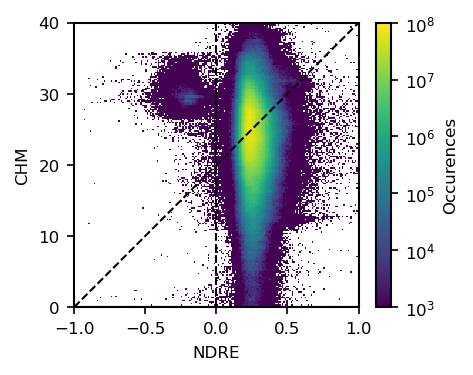

In [77]:
bins = 200

# x_name = 'ndvi'
# x_name = 'ndvire'
x_name = 'ndre'
# x_name = 'grvi'

# y_name = 'ndvi'
# y_name = 'ndvire'
# y_name = 'ndre'
# y_name = 'grvi'
y_name = 'chm'

x = vi[:, vi_names.index(x_name)]
y = vi[:, vi_names.index(y_name)]

H, xedges, yedges = np.histogram2d(
    x,
    y,
    bins = [bins, bins],
    range = [[-1,1], [0,40]],
)
H = np.log(H.T)

f = plt.figure(figsize=[3,3])
ax = f.add_subplot()

mapp = plt.imshow(
    H,
    interpolation='nearest',
    origin='lower',
    extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
    vmin=3,
    vmax=8,
    aspect=5e-2,
    )
plt.colorbar(
    mapp,
    ax=ax,
    shrink=0.8,
    format=r'$10^{%i}$',
    label='Occurences'
    )

ax.plot(
    [xedges[0], xedges[-1]],
    [yedges[0], yedges[-1]],
    '--',
    c='k',
    lw=1,
)
ax.axhline(0, ls='--', c='k', lw=1)
ax.axvline(0, ls='--', c='k', lw=1)

_ = ax.set_xlabel(x_name.upper())
_ = ax.set_xlim(xedges[0],xedges[1])
_ = ax.set_xticks(np.linspace(xedges[0],xedges[-1],5))

_ = ax.set_ylabel(y_name.upper())
_ = ax.set_ylim(yedges[0],yedges[1])
_ = ax.set_yticks(np.linspace(yedges[0],yedges[-1],5))


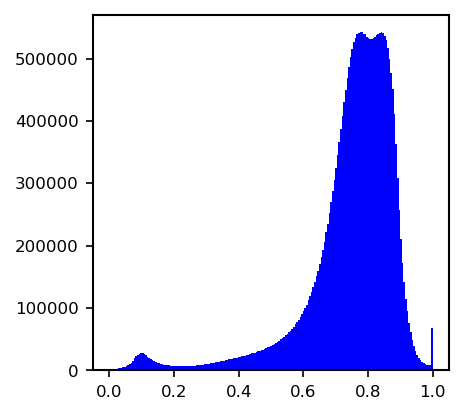

In [17]:
bins = np.linspace(0, 1, 200)
x_name = 'ndvi'
# x_name = 'ndvire'
# x_name = 'ndre'
# x_name = 'grvi'
# x_name = 'osavi'
# x_name = 'light'

# y_name = 'ndvi'
y_name = 'ndvire'
# y_name = 'ndre'
# y_name = 'grvi'
# y_name = 'osavi'
# y_name = 'light'


x = vi[:, vi_names.index(x_name)]
y = vi[:, vi_names.index(y_name)]


f = plt.figure(figsize=[3,3])
ax = f.add_subplot()
_ = ax.hist(
    (x+y)/2,
    bins=bins,
)
# ax.set_yscale('log')